# 투자분석 hw4

20249433 최재필


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm

import yfinance as yf

## (a)

- MSFT
- GOOG
- KO

Source: Yahoo Finance

In [2]:
START = '2015-01-01'
END = '2019-12-31'

In [3]:
MSFT = yf.Ticker("HPQ") # originally MSFT
GOOG = yf.Ticker("BP") # originally GOOGL
KO = yf.Ticker("TGT") # originally KO

SPY = yf.Ticker("SPY")
Tbill3M = yf.Ticker("^IRX")

In [4]:
MSFT_df = MSFT.history(start=START, end=END, interval='1mo')
MSFT_ret = MSFT_df['Close'].pct_change().dropna()
MSFT_ret = MSFT_ret.rename('MSFT')

GOOG_df = GOOG.history(start=START, end=END, interval='1mo')
GOOG_ret = GOOG_df['Close'].pct_change().dropna()
GOOG_ret = GOOG_ret.rename('GOOG')

KO_df = KO.history(start=START, end=END, interval='1mo')
KO_ret = KO_df['Close'].pct_change().dropna()
KO_ret = KO_ret.rename('KO')

SPY_df = SPY.history(start=START, end=END, interval='1mo')
SPY_ret = SPY_df['Close'].pct_change().dropna()
SPY_ret = SPY_ret.rename('SPY')

Tbill3M_df = Tbill3M.history(start=START, end=END, interval='1mo')
Tbill3M_ret = Tbill3M_df['Close']
Tbill3M_ret = Tbill3M_ret.rename('Tbill3M')
Tbill3M_ret = Tbill3M_ret / 100 / 12 # convert to monthly rate

In [5]:
MSFT_ret.index = MSFT_ret.index.to_period('M')
GOOG_ret.index = GOOG_ret.index.to_period('M')
KO_ret.index = KO_ret.index.to_period('M')
SPY_ret.index = SPY_ret.index.to_period('M')
Tbill3M_ret.index = Tbill3M_ret.index.to_period('M')

Tbill3M_ret = Tbill3M_ret.reindex(MSFT_ret.index, method='ffill')

C:\Users\chlje\AppData\Local\Temp\ipykernel_32404\452896683.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  MSFT_ret.index = MSFT_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_32404\452896683.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  GOOG_ret.index = GOOG_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_32404\452896683.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  KO_ret.index = KO_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_32404\452896683.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  SPY_ret.index = SPY_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_32404\452896683.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  Tbill3M_ret.index 

In [6]:
df = pd.concat([MSFT_ret, GOOG_ret, KO_ret, SPY_ret, Tbill3M_ret], axis=1)
df = df.dropna()

In [7]:
# Make it excess return
excs_df = df.loc[:, ['MSFT', 'GOOG', 'KO', 'SPY']].subtract(df.loc[:, 'Tbill3M'], axis=0)
excs_df.columns = [f'{ticker}_excs' for ticker in excs_df.columns]
excs_df.tail()

,MSFT_excs,GOOG_excs,KO_excs,SPY_excs
Date,,,,
2019-08,-0.132314,-0.071817,0.237278,-0.018354
2019-09,0.032970,0.043791,0.004983,0.013297
2019-10,-0.075379,-0.003354,-0.001248,0.025576
2019-11,0.154733,-0.014209,0.168018,0.034915
2019-12,0.022152,0.023290,0.030426,0.022767


## (b)

In [8]:
stocks = ['MSFT', 'GOOG', 'KO']

def get_SIM_regression(stock_returns, market_returns, print_summary=True):
    X = sm.add_constant(market_returns)
    model = sm.OLS(stock_returns, X)
    results = model.fit()

    if print_summary:
        print(results.summary())

    return results

각 종목의 초과수익률을 시장 초과수익률에 대해 regress

In [9]:
results = {}

for stock in stocks:
    print(f'SIM regression result of {stock}')
    results[stock] = get_SIM_regression(excs_df[f'{stock}_excs'], excs_df['SPY_excs'], print_summary=True)
    print('\n'*5)

SIM regression result of MSFT
                            OLS Regression Results                            
Dep. Variable:              MSFT_excs   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     42.78
Date:                Tue, 04 Jun 2024   Prob (F-statistic):           1.85e-08
Time:                        22:09:56   Log-Likelihood:                 85.373
No. Observations:                  59   AIC:                            -166.7
Df Residuals:                      57   BIC:                            -162.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0051 

In [10]:
def get_result_values(single_stock_result):
    alpha, beta = single_stock_result.params
    t_value_alpha, t_value_beta = single_stock_result.tvalues
    p_value_alpha, p_value_beta = single_stock_result.pvalues
    r_squared = single_stock_result.rsquared

    # residual std는 따로 계산해야 함
    residuals = single_stock_result.resid
    resid_df = single_stock_result.df_resid
    residual_std = np.sqrt( (residuals**2).sum() / resid_df )

    result_values = {
        'alpha': alpha,
        'beta': beta,
        't_value_alpha': t_value_alpha,
        't_value_beta': t_value_beta,
        'p_value_alpha': p_value_alpha,
        'p_value_beta': p_value_beta,
        'r_squared': r_squared,
        'residual_std': residual_std
    }

    return result_values


In [11]:
msft_result_values = get_result_values(results['MSFT'])
goog_result_values = get_result_values(results['GOOG'])
ko_result_values = get_result_values(results['KO'])


In [12]:
msft_result_values

{'alpha': -0.0051259585084919655,
 'beta': 1.406185892961618,
 't_value_alpha': -0.6562639007621255,
 't_value_beta': 6.540639783678461,
 'p_value_alpha': 0.5142949899641238,
 'p_value_beta': 1.8466001061280665e-08,
 'r_squared': 0.4287430563766823,
 'residual_std': 0.057919451741459585}

In [13]:
goog_result_values

{'alpha': -0.0008265170487031098,
 'beta': 0.7299857604360439,
 't_value_alpha': -0.10231330121812508,
 't_value_beta': 3.2829837713521832,
 'p_value_alpha': 0.918867089966607,
 'p_value_beta': 0.0017578355984979742,
 'r_squared': 0.15901893291131775,
 'residual_std': 0.05990286441462835}

In [14]:
ko_result_values

{'alpha': 0.009352022246571563,
 'beta': 0.4885656080065153,
 't_value_alpha': 0.9680016967001229,
 't_value_beta': 1.837246992788653,
 'p_value_alpha': 0.3371330347574454,
 'p_value_beta': 0.0713882467844006,
 'r_squared': 0.05590807240770135,
 'residual_std': 0.07164028155773823}

## (c)

In [15]:
mkt_excs_mean = excs_df['SPY_excs'].mean() # Market expected return
mkt_excs_std = excs_df['SPY_excs'].std() # Market expected volatility

In [16]:
ann_mkt_excs_mean = mkt_excs_mean * 12
ann_mkt_excs_std = mkt_excs_std * np.sqrt(12)

In [18]:
betas = np.array([msft_result_values['beta'], goog_result_values['beta'], ko_result_values['beta']])
betas

array([1.40618589, 0.72998576, 0.48856561])

In [19]:
msft_excs_std = excs_df['MSFT_excs'].std()
goog_excs_std = excs_df['GOOG_excs'].std()
ko_excs_std = excs_df['KO_excs'].std()

excs_stds = np.array([msft_excs_std, goog_excs_std, ko_excs_std])
excs_stds

array([0.07596825, 0.06475569, 0.07309263])

In [20]:
ann_excs_stds = excs_stds * np.sqrt(12)

In [21]:
sys_stds = betas * ann_mkt_excs_std
sys_stds

array([0.17231429, 0.0894526 , 0.05986892])

In [22]:
resid_stds = np.sqrt(ann_excs_stds**2 - sys_stds**2)
resid_stds

array([0.1989017 , 0.20571296, 0.24602052])

In [49]:
alphas = [0.02, -0.01, 0.01] # already annualized

In [48]:
ANN_MKT_RISKPREMIUM = 0.06

riskpremiums = ANN_MKT_RISKPREMIUM * betas
riskpremiums

array([0.08437115, 0.04379915, 0.02931394])

### 교수님 엑셀처럼 값 정리하여 optimal risky portfolio 구하기

#### $ \sigma^2(\epsilon_i) $ 

In [25]:
resid_vars = resid_stds**2
resid_vars

array([0.03956189, 0.04231782, 0.0605261 ])

#### $ \alpha_i / \sigma^2(\epsilon_i) $

In [24]:
alpha_div_resid_vars = alphas / resid_vars
alpha_div_resid_vars

array([ 0.50553707, -0.23630707,  0.16521799])

#### $ w_i $

In [27]:
weights = alpha_div_resid_vars / alpha_div_resid_vars.sum()
weights

array([ 1.16363083, -0.54392488,  0.38029406])

In [29]:
np.round(weights.sum(), 10)

1.0

#### $ \alpha_A $

In [30]:
weighted_alpha = weights @ alphas
weighted_alpha

0.03251480591481663

#### $ \beta_A $

In [31]:
weighted_beta = weights @ betas
weighted_beta

1.4250224299543568

#### $ \sigma^2(\epsilon_A) $ - residual variance

In [32]:
active_residual_var = weights**2 @ resid_vars
active_residual_var

0.07484165465314446

#### $ \sigma_A^2 $ - active portfolio variance


In [33]:
active_port_var = weighted_beta**2 * ann_mkt_excs_std**2 + active_residual_var
active_port_var

0.10533468087599132

#### $ w_A^0 $

In [34]:
w_A_0 = (weighted_alpha / active_residual_var) / (mkt_excs_mean / mkt_excs_std**2) # 여기서 lookahead std로 넣었다. 원래는 historical 쓰던데.
w_A_0

0.057372223664012637

#### $ w_A^* $

In [35]:
w_A_star = w_A_0 / (1 + w_A_0 * (1 - weighted_beta))
w_A_star

0.05880618194403262

개별 주식 weight

In [36]:
final_weights = w_A_star * weights
final_weights

array([ 0.06842869, -0.03198615,  0.02236364])

#### $ w_M^* $

In [38]:
w_M_star = 1 - w_A_star
w_M_star

0.9411938180559674

### 그래프 확인

In [41]:
final_weights

array([ 0.06842869, -0.03198615,  0.02236364])

<Axes: xlabel='Date'>

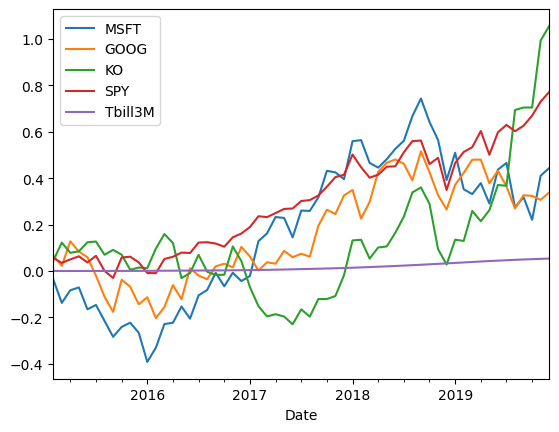

In [40]:
((1 + df).cumprod() - 1).plot()

In [42]:
final_alpha = final_weights @ alphas
final_alpha

0.0019120715925016153

In [43]:
final_std = np.sqrt(final_weights @ resid_vars)
final_std

0.05203045176788102

## (d)

Information ratio

In [44]:
information_ratio = final_alpha / final_std
information_ratio

0.03674908688150116

## (e)

In [50]:
active_riskpremium = final_weights @ riskpremiums
active_riskpremium

0.005028007697413403

In [51]:
optimal_riskpremium = ANN_MKT_RISKPREMIUM * w_M_star + active_riskpremium * w_A_star
optimal_riskpremium

0.05676730701882813

In [54]:
market_sharpe = ANN_MKT_RISKPREMIUM / ann_mkt_excs_std
market_sharpe

0.4896352622184936

In [56]:
optimal_sharpe = np.sqrt(market_sharpe ** 2 + information_ratio ** 2)
optimal_sharpe

0.49101240859513634